In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vit122/jx_vit_base_patch16_384_in21k-0243c7d9.pth
/kaggle/input/vit122/jx_vit_base_p32_384-830016f5.pth
/kaggle/input/vit122/jx_vit_base_p16_384-83fb41ba.pth
/kaggle/input/vit122/jx_vit_base_p16_224-80ecf9dd.pth
/kaggle/input/banana1/dataset/unripe/ur(357).jpg
/kaggle/input/banana1/dataset/unripe/ur(694).jpg
/kaggle/input/banana1/dataset/unripe/ur(278).jpg
/kaggle/input/banana1/dataset/unripe/ur(1340).jpg
/kaggle/input/banana1/dataset/unripe/ur(409).jpg
/kaggle/input/banana1/dataset/unripe/ur(608).jpg
/kaggle/input/banana1/dataset/unripe/ur(773).jpg
/kaggle/input/banana1/dataset/unripe/ur(515).jpg
/kaggle/input/banana1/dataset/unripe/ur(837).jpg
/kaggle/input/banana1/dataset/unripe/ur(1003).jpg
/kaggle/input/banana1/dataset/unripe/ur(1069).jpg
/kaggle/input/banana1/dataset/unripe/ur(869).jpg
/kaggle/input/banana1/dataset/unripe/ur(543).jpg
/kaggle/input/banana1/dataset/unripe/ur(1483).jpg
/kaggle/input/banana1/dataset/unripe/ur(1358).jpg
/kaggle/input/banana1/dataset/unri

In [2]:
!pip install split-folders

In [3]:
pip install vit-keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os 
import glob as gb

from sklearn.model_selection import train_test_split

import timm 

import torch 
import torch.nn as nn 
from torch.optim import Adam , lr_scheduler 
from torch.utils.data import Dataset , DataLoader 
from torchinfo import summary 
import torchvision 
import torchvision.transforms as transforms
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
# import system libs
import os
import itertools
from PIL import Image # pillow

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from vit_keras import vit

print ('modules loaded')

2024-04-02 09:43:14.801320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 09:43:14.801370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 09:43:14.802879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [5]:
# !pip install 'keras<3.0.0' mediapipe-model-maker

In [6]:
!pip install tensorflow-addons==0.23.0

In [7]:
base_ds = '/kaggle/input/banana1/dataset'
base_ds = pathlib.Path(base_ds)
splitfolders.ratio(base_ds, output='banana image dataset', seed=123, ratio=(.8,.2), group_prefix=None)

Copying files: 4500 files [00:06, 713.60 files/s] 


In [8]:
# Generate data paths with labels
train_data_dir = '/kaggle/working/banana image dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [9]:
# Generate data paths with labels
test_data_dir = '/kaggle/working/banana image dataset/val'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis=1)

In [10]:
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=123)

In [11]:
# Image size
batch_size =32
img_size = (224, 224, 3)  # Adding the channels dimension

# Data Generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(img_size[0], img_size[1]),
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(img_size[0], img_size[1]),
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(img_size[0], img_size[1]),
                                     class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3600 validated image filenames belonging to 3 classes.
Found 450 validated image filenames belonging to 3 classes.
Found 450 validated image filenames belonging to 3 classes.


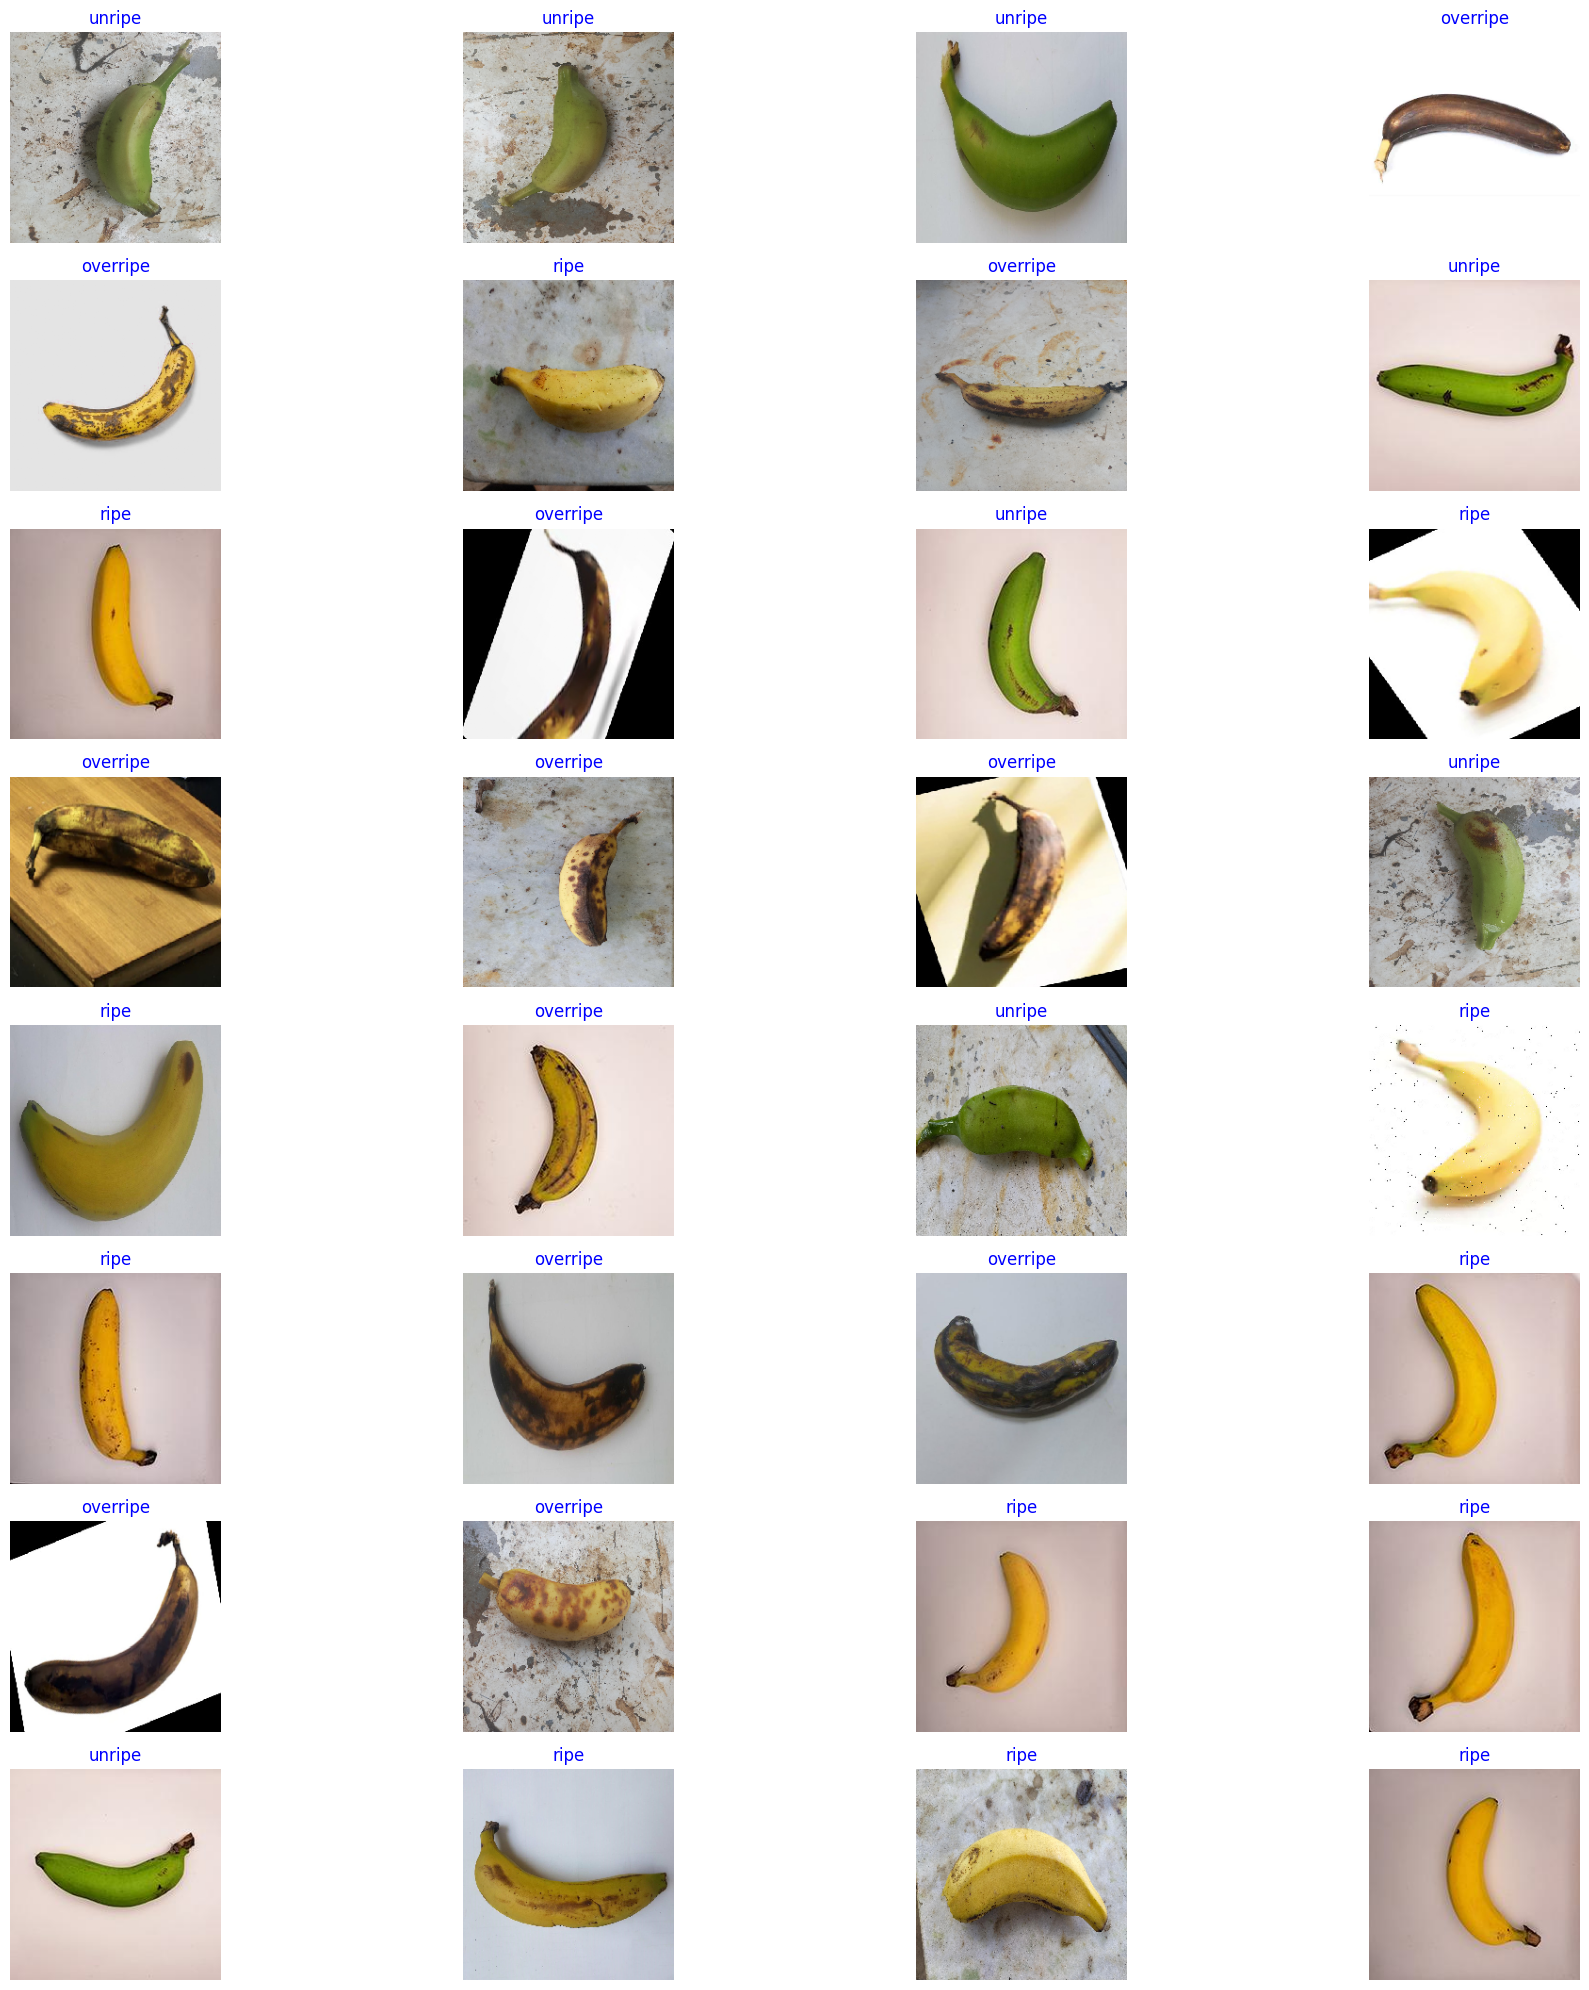

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator
images, labels = next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(batch_size):
    plt.subplot(batch_size // 4, 4, i + 1) 
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# ViT Model
class_count = len(list(train_gen.class_indices.keys()))
model = vit.vit_b16(
    image_size=img_size[0],
    activation='softmax',
    pretrained=True,
    include_top=True,
    classes=class_count,
    pretrained_top=False,
)

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [14]:
epochs = 25
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/25


I0000 00:00:1712051061.903537    2539 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 [==============================] - 201s 1s/step - loss: 1.2190 - accuracy: 0.4569 - val_loss: 0.6410 - val_accuracy: 0.7444
Epoch 2/25
113/113 [==============================] - 157s 1s/step - loss: 0.5210 - accuracy: 0.7736 - val_loss: 0.6898 - val_accuracy: 0.7356
Epoch 3/25
113/113 [==============================] - 156s 1s/step - loss: 0.3070 - accuracy: 0.8781 - val_loss: 0.2963 - val_accuracy: 0.8978
Epoch 4/25
113/113 [==============================] - 157s 1s/step - loss: 0.2384 - accuracy: 0.9114 - val_loss: 0.2564 - val_accuracy: 0.8867
Epoch 5/25
113/113 [==============================] - 157s 1s/step - loss: 0.1630 - accuracy: 0.9419 - val_loss: 0.1209 - val_accuracy: 0.9467
Epoch 6/25
113/113 [==============================] - 158s 1s/step - loss: 0.1140 - accuracy: 0.9572 - val_loss: 0.0814 - val_accuracy: 0.9622
Epoch 7/25
113/113 [==============================] - 157s 1s/step - loss: 0.1063 - accuracy: 0.9611 - val_loss: 0.0931 - val_accuracy: 0.9733
Epoch 8/25

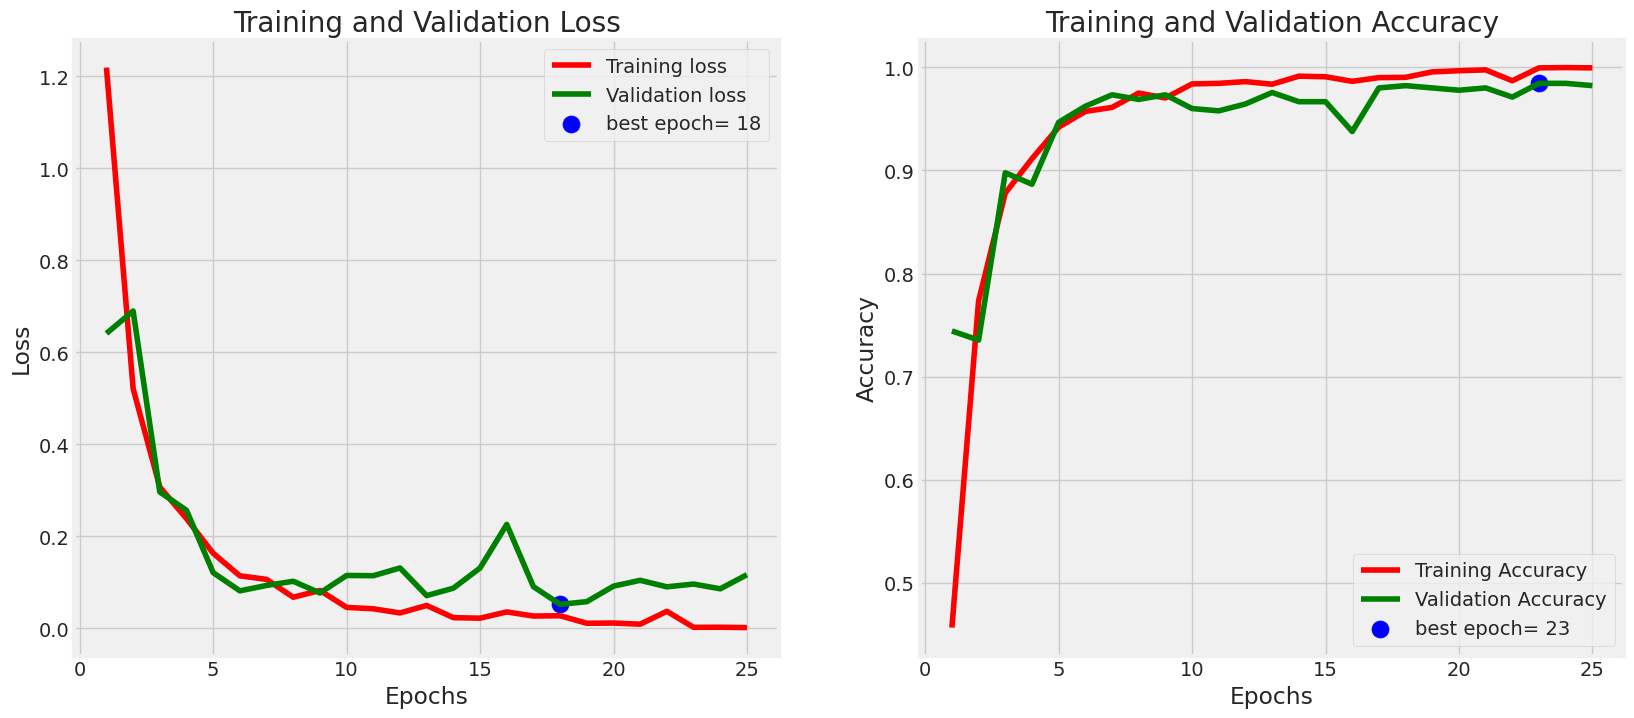

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
# Evaluation
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 7s 458ms/step - loss: 0.1907 - accuracy: 0.9778
Train Loss:  5.009165397495963e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.11641157418489456
Validation Accuracy:  0.9822221994400024
--------------------
Test Loss:  0.19074192643165588
Test Accuracy:  0.9777777791023254


In [17]:
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 

15/15 [==============================] - 11s 477ms/step


In [19]:
# Classification Report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

    overripe       0.99      0.95      0.97       156
        ripe       0.96      0.99      0.97       157
      unripe       0.99      1.00      0.99       137

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



15/15 [==============================] - 7s 455ms/step


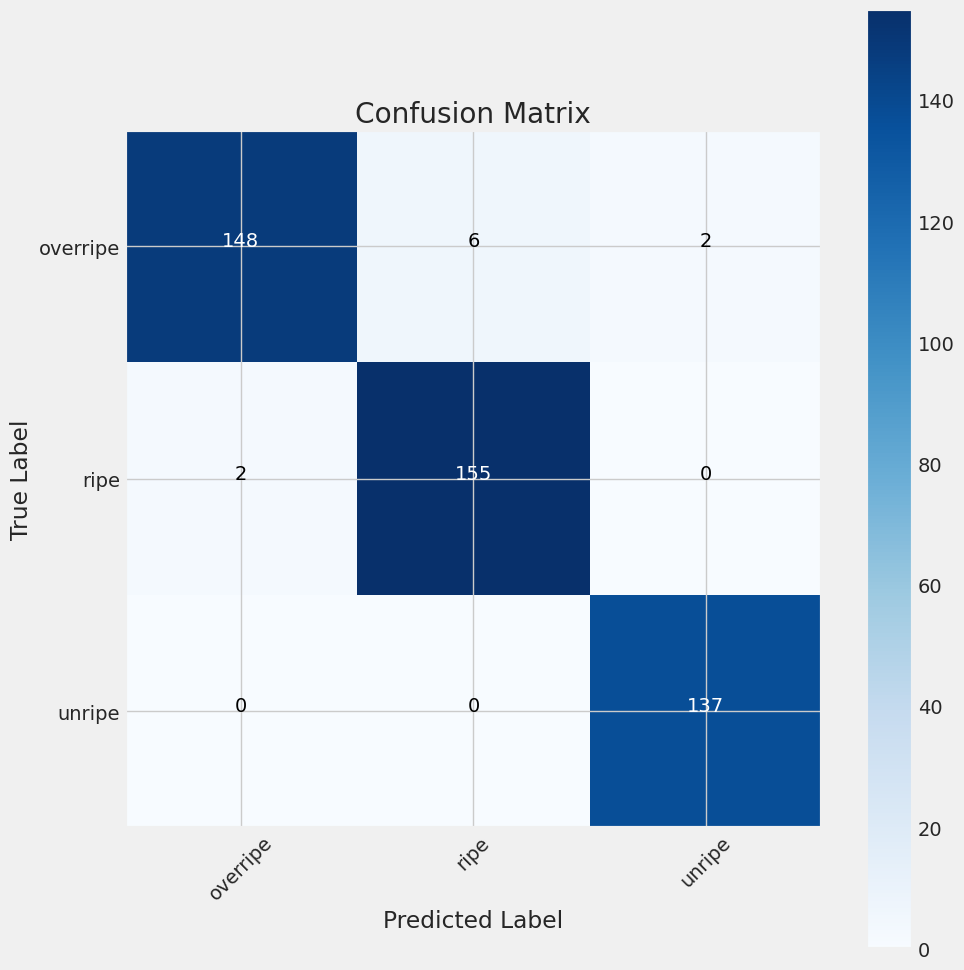

In [18]:
# Confusion Matrix
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
model.save('BANANA with ViT.keras')